In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Libraries** bold text

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


# **Prepraing the Dataset**

In [3]:
ravdess = '/content/drive/My Drive/ravdess/audio_actors'
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_16', 'Actor_15', 'Actor_14', 'Actor_12', 'Actor_11', 'Actor_13', 'Actor_09', 'Actor_10', 'Actor_08', 'Actor_02', 'Actor_07', 'Actor_01', 'Actor_05', 'Actor_04', 'Actor_03', 'Actor_06', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    actor_path = os.path.join(ravdess, i)
    actor = os.listdir(actor_path)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(actor_path, f))

In [5]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust',
                             8:'surprised'},
                            inplace=True)


<ipython-input-5-3cd4b8cb67f6>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust',


In [6]:
ravdess_df.to_csv("ravdess_df",index=False)

In [7]:
print(ravdess_df.Emotions.value_counts())

Emotions
calm         192
happy        192
sad          192
disgust      192
angry        192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64


# **Data Visualtion**

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

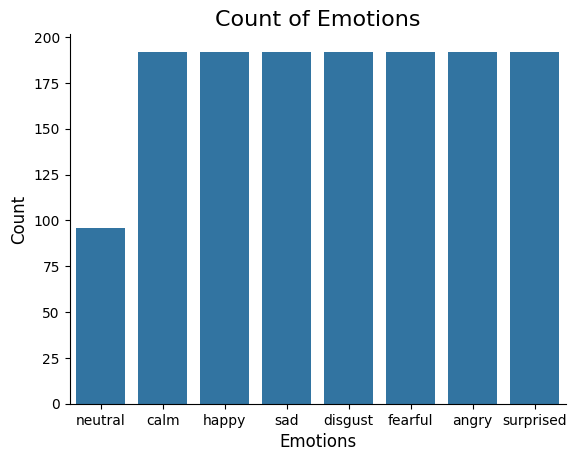

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=ravdess_df.Emotions)
plt.ylabel('Count', size = 12)
plt.xlabel('Emotions', size = 12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# **Implementing the MFCC features**

In [10]:
# Adding Noise
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Stretching the audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# shift
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [11]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)


def calculate_rmse(data,frame_length=2048,hop_length=512):
    rmse_val=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse_val)


def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      calculate_rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result


def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [12]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(ravdess_df.Path,ravdess_df.Emotions,range(ravdess_df.Path.shape[0]))):
    features = get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:19, 19.73s/it]

0 audio has been processed


501it [09:22,  1.05s/it]

500 audio has been processed


1001it [18:49,  1.00it/s]

1000 audio has been processed


1440it [26:51,  1.12s/it]

Done
Time:  1611.7811405320003


In [13]:
print(X)

[array([0.29345703, 0.36572266, 0.43066406, ..., 0.91468954, 1.24533689,
       1.42160571]), array([ 0.24853516,  0.36230469,  0.48339844, ...,  2.85681082,
        1.82034066, -3.68625323]), array([ 0.12597656,  0.140625  ,  0.17529297, ...,  0.07845464,
       -0.19535741, -0.44445711]), array([ 0.22802734,  0.34863281,  0.46191406, ..., -4.1812446 ,
        3.02247001,  3.26239641]), array([0.390625  , 0.56054688, 0.77636719, ..., 1.84911585, 1.88157225,
       1.09398293]), array([ 0.25439453,  0.39257812,  0.51660156, ..., -9.59554074,
       -5.28373961, -5.33485182]), array([ 0.28271484,  0.43212891,  0.58496094, ...,  1.81064439,
        1.04517865, -0.39255983]), array([ 0.23046875,  0.35205078,  0.47119141, ..., -1.3021942 ,
       -1.74203535, -0.95752979]), array([ 0.        ,  0.        ,  0.        , ..., -4.59638119,
       -3.43595099, -2.37282658]), array([ 0.24951172,  0.3671875 ,  0.49414062, ..., -5.47716051,
       -0.35613327,  1.10392156]), array([ 0.        ,  

In [14]:
print(Y)

['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'calm', 'neutral', 'neutral', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'calm', 'neutral', 'neutral', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm', 'sad', 'sad', 'sad', 'sad', 'calm', 'calm', 'calm', 'calm', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'calm', 'calm', 'calm', 'calm', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad', 'sad', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 

In [15]:
len(X), len(Y), ravdess_df.Path.shape

(5760, 5760, (1440,))

In [16]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.293457,0.365723,0.430664,0.312500,0.286621,0.297363,0.313477,0.318848,0.372559,0.376953,...,1.018232,0.266373,-0.348294,-0.518506,-0.186301,0.395265,0.914690,1.245337,1.421606,neutral
1,0.248535,0.362305,0.483398,0.477051,0.479492,0.494629,0.497559,0.503906,0.514160,0.509277,...,1.141337,1.284543,-0.602416,3.322278,-0.632250,0.549231,2.856811,1.820341,-3.686253,neutral
2,0.125977,0.140625,0.175293,0.150391,0.181641,0.242188,0.303711,0.316406,0.301270,0.258301,...,2.125674,1.752258,1.386205,1.032266,0.694367,0.375638,0.078455,-0.195357,-0.444457,neutral
3,0.228027,0.348633,0.461914,0.465332,0.479004,0.480957,0.493652,0.501465,0.486328,0.487793,...,1.565868,-1.175680,-6.326599,1.752834,0.993512,-6.001181,-4.181245,3.022470,3.262396,neutral
4,0.390625,0.560547,0.776367,0.765137,0.822266,0.879395,0.850586,0.862793,0.863770,0.867188,...,-0.375159,-1.341119,-1.612453,-0.962625,0.161264,1.191060,1.849116,1.881572,1.093983,neutral


In [17]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.293457,0.365723,0.430664,0.312500,0.286621,0.297363,0.313477,0.318848,0.372559,0.376953,...,1.018232,0.266373,-0.348294,-0.518506,-0.186301,0.395265,0.914690,1.245337,1.421606,neutral
1,0.248535,0.362305,0.483398,0.477051,0.479492,0.494629,0.497559,0.503906,0.514160,0.509277,...,1.141337,1.284543,-0.602416,3.322278,-0.632250,0.549231,2.856811,1.820341,-3.686253,neutral
2,0.125977,0.140625,0.175293,0.150391,0.181641,0.242188,0.303711,0.316406,0.301270,0.258301,...,2.125674,1.752258,1.386205,1.032266,0.694367,0.375638,0.078455,-0.195357,-0.444457,neutral
3,0.228027,0.348633,0.461914,0.465332,0.479004,0.480957,0.493652,0.501465,0.486328,0.487793,...,1.565868,-1.175680,-6.326599,1.752834,0.993512,-6.001181,-4.181245,3.022470,3.262396,neutral
4,0.390625,0.560547,0.776367,0.765137,0.822266,0.879395,0.850586,0.862793,0.863770,0.867188,...,-0.375159,-1.341119,-1.612453,-0.962625,0.161264,1.191060,1.849116,1.881572,1.093983,neutral


# **Handling Missing values**

In [18]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [19]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [20]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


# **Data Preparation**

In [21]:
X = Emotions.iloc[: ,:-1].values # the last col of Emotions dataframe contains the labels
Y = Emotions['Emotions'].values

# **Encoding our categorical values**

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [23]:
import numpy as np

max_len = max(len(seq) for seq in X)

# Padding sequences with zeros to match the maximum length
X_padded = [np.pad(seq, (0, max_len - len(seq)), 'constant') for seq in X]

X = np.array(X_padded)

print(Y.shape)
print(X.shape)

(5760, 8)
(5760, 2376)


# **Splitting into Training and Testing set**

In [24]:
X = Emotions.iloc[:, :-1].values
Y = Emotions['Emotions'].values

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

import numpy as np
num_augmentations = X.shape[0] // Y.shape[0]
Y = np.repeat(Y, num_augmentations, axis=0)


max_len = max(len(seq) for seq in X)
X_padded = [np.pad(seq, (0, max_len - len(seq)), 'constant') for seq in X]
X = np.array(X_padded)

# train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [25]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [26]:
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


In [42]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model1.keras', monitor='val_accuracy', save_best_only=True)


In [43]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [44]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((4608, 2376, 1), (4608, 8), (1152, 2376, 1), (1152, 8))

In [48]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

model = Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_traincnn.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='best_model1_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True
)

history = model.fit(
    x_traincnn,
    y_train,
    epochs=50,
    validation_data=(x_testcnn, y_test),
    batch_size=32,
    callbacks=[model_checkpoint]
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.3602 - loss: 2.0993 - val_accuracy: 0.1354 - val_loss: 5.3552
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5906 - loss: 1.1290 - val_accuracy: 0.1094 - val_loss: 3.7840
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7029 - loss: 0.8214 - val_accuracy: 0.1997 - val_loss: 5.2771
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7723 - loss: 0.6614 - val_accuracy: 0.4245 - val_loss: 1.9461
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8581 - loss: 0.4177 - val_accuracy: 0.6432 - val_loss: 1.1458
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9193 - loss: 0.2693 - val_accuracy: 0.6736 - val_loss: 0.9615
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9295 - loss: 0.2176 - val_accuracy: 0.7986 - val_loss: 0.6268
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9633 - loss: 0.1245 - val_acc

In [50]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential

model = Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_traincnn.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.load_weights('/content/best_model1_weights.weights.h5')

print("Model architecture recreated and weights loaded successfully!")


Model architecture recreated and weights loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
model_checkpoint = ModelCheckpoint('best_model1.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

# Train the model
history = model.fit(
    x_traincnn, y_train,
    epochs=50,
    validation_data=(x_testcnn, y_test),
    batch_size=32,
    callbacks=[model_checkpoint, early_stop, lr_reduction]
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9867 - loss: 0.0431 - val_accuracy: 0.8125 - val_loss: 0.7330 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9779 - loss: 0.0765 - val_accuracy: 0.8707 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9902 - loss: 0.0366 - val_accuracy: 0.7769 - val_loss: 0.8720 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9820 - loss: 0.0588 - val_accuracy: 0.8776 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9892 - loss: 0.0341 - val_accuracy: 0.8568 - val_loss: 0.5177 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9892 - loss: 0.0294 - val_accuracy: 0.8750 - val_loss: 0.4960 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9921 - loss: 0

In [60]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

model = tf.keras.models.load_model('best_model1.keras')

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    result = np.hstack((result, np.squeeze(zcr)))
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    result = np.hstack((result, np.squeeze(rmse)))
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    result = np.hstack((result, np.ravel(mfcc.T)))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    return extract_features(data)

new_audio_file = "/content/test.wav" # loading the audio file


new_audio_features = get_features(new_audio_file)

new_audio_features = np.expand_dims(new_audio_features, axis=0)

scaler = StandardScaler()
new_audio_features = scaler.fit_transform(new_audio_features)

new_audio_features = np.expand_dims(new_audio_features, axis=2)


prediction = model.predict(new_audio_features)

predicted_emotion_index = np.argmax(prediction)

predicted_emotion = emotion_labels[predicted_emotion_index]

print(f"The predicted emotion for the new audio file is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
The predicted emotion for the new audio file is: disgust
